In [112]:
%pylab inline
import pylab as pl
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from scipy.stats.mstats import mquantiles
pl.gray()


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.kernel.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


In [3]:
olivetti = fetch_olivetti_faces()
faces = olivetti.images
faces_train, faces_test, target_train, target_test = train_test_split(
    olivetti.images, olivetti.target)

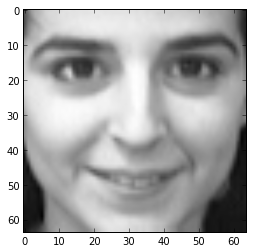

In [4]:
pl.imshow(faces_train[0])

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

In [6]:
pe = PatchExtractor((8, 8), random_state=42)
patches = pe.transform(faces_train)

In [7]:
patches.shape

(974700, 8, 8)

In [8]:
patches = patches.reshape(-1, 64)

In [9]:
def plot_patches(patches, n_rows=8, n_cols=12):
    pl.figure(figsize=(1.2 * n_cols, 1.2 * n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < len(patches):
                pl.subplot(n_rows, n_cols, i * n_cols + j)
                pl.imshow(patches[idx].reshape(8, 8), interpolation='nearest')
                pl.axis('off')

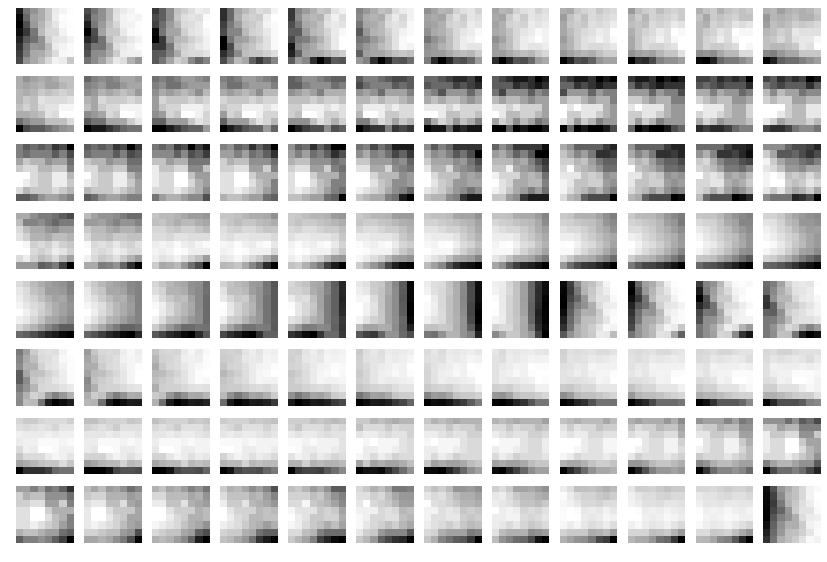

In [10]:
plot_patches(patches)

In [11]:
n_patches = 100000

patches = shuffle(patches)[:n_patches]

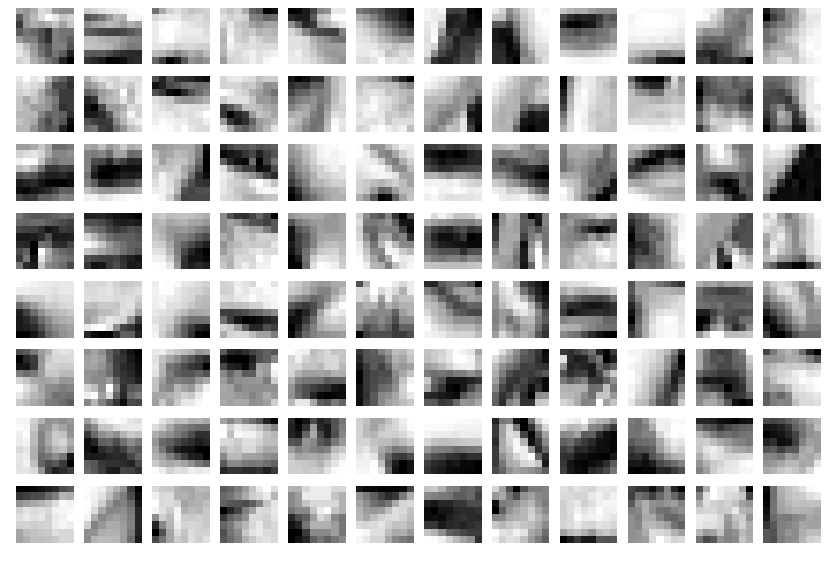

In [12]:
plot_patches(patches)

In [13]:
patches_centered = patches - patches.mean(axis=1).reshape(n_patches, 1)

In [14]:
from sklearn.preprocessing import normalize

patches_normalized = normalize(patches_centered)

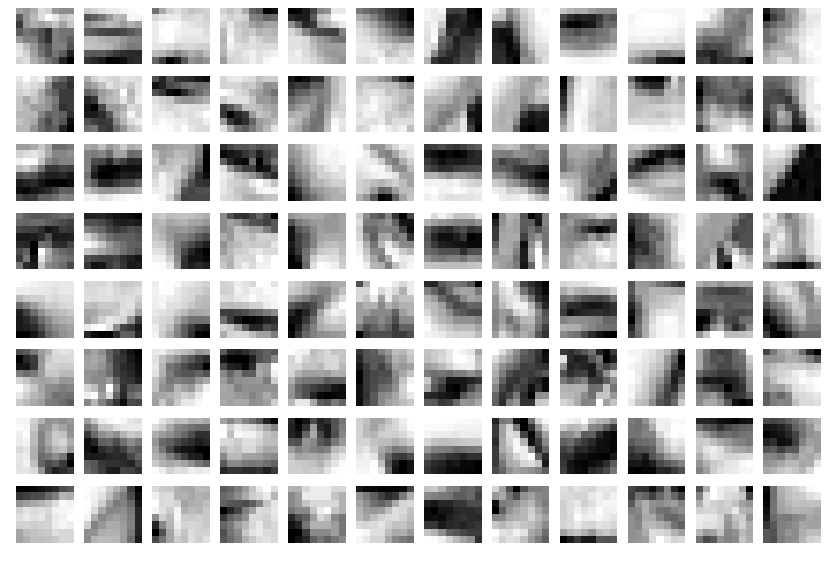

In [15]:
plot_patches(patches_normalized)

In [16]:
from sklearn.cluster import MiniBatchKMeans

In [17]:
km_10 = MiniBatchKMeans(n_clusters=10, batch_size=1000, verbose=0, n_init=3, random_state=42)
%time km_10.fit(patches_normalized)

CPU times: user 624 ms, sys: 77.2 ms, total: 702 ms
Wall time: 673 ms


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [18]:
centroids_10 = normalize(km_10.cluster_centers_)
activations_10 = np.dot(patches_normalized, centroids_10.T)

In [19]:
def plot_activations(activations, n_rows=8, n_cols=12, bins=10):
    pl.figure(figsize=(1.2 * n_cols, 1.2 * n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < len(patches):
                pl.subplot(n_rows, n_cols, i * n_cols + j)
                pl.title("{:0.2f}".format(np.median(activations[:, idx])))
                pl.hist(activations[:, idx], bins=bins)
                pl.axis('off')

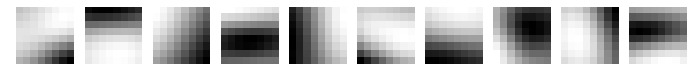

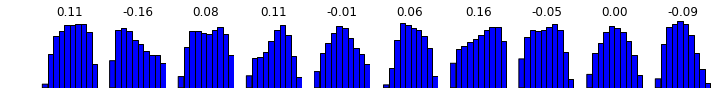

In [20]:
plot_patches(centroids_10, n_rows=1, n_cols=10)
plot_activations(activations_10, n_rows=1, n_cols=10)

In [21]:
km_100 = MiniBatchKMeans(n_clusters=100, batch_size=1000, verbose=0, n_init=3, random_state=42)
%time km_100.fit(patches_normalized)

CPU times: user 2.38 s, sys: 105 ms, total: 2.49 s
Wall time: 2.31 s


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=3, random_state=42, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [22]:
centroids_100 = normalize(km_100.cluster_centers_)
activations_100 = np.dot(patches_normalized, centroids_100.T)

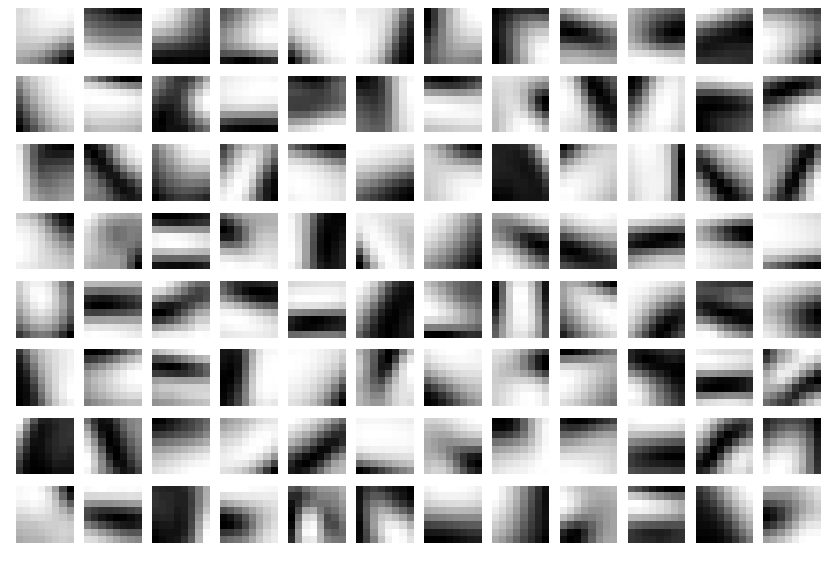

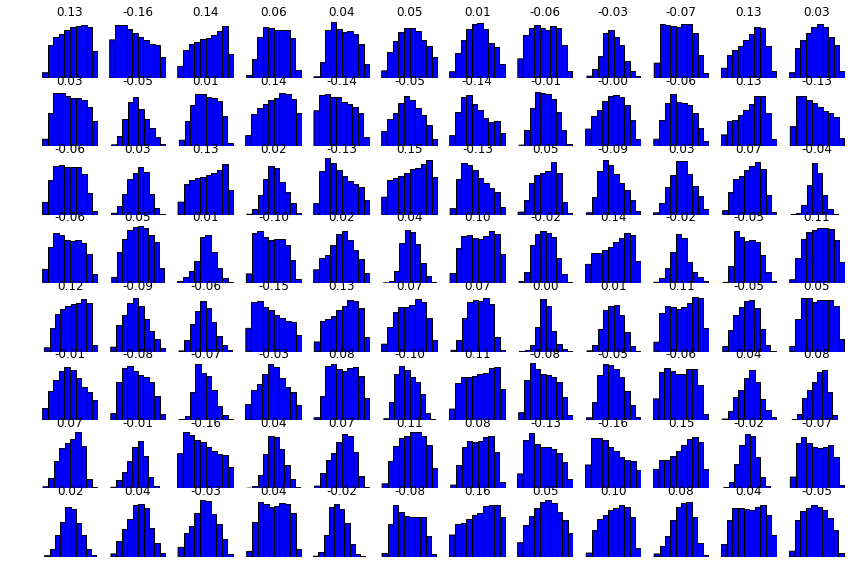

In [23]:
plot_patches(centroids_100)
plot_activations(activations_100)

In [24]:
km_1000 = MiniBatchKMeans(n_clusters=1000, batch_size=1000, verbose=0, n_init=3, random_state=42)
%time km_1000.fit(patches_normalized)

CPU times: user 24.8 s, sys: 1.13 s, total: 25.9 s
Wall time: 23.6 s


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=1000, n_init=3, random_state=42,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [25]:
centroids_1000 = normalize(km_1000.cluster_centers_)
activations_1000 = np.dot(patches_normalized, centroids_1000.T)

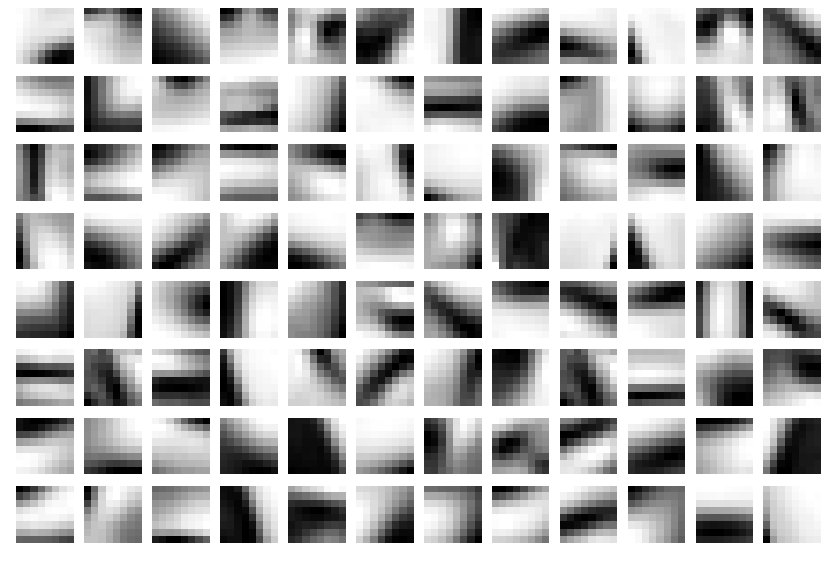

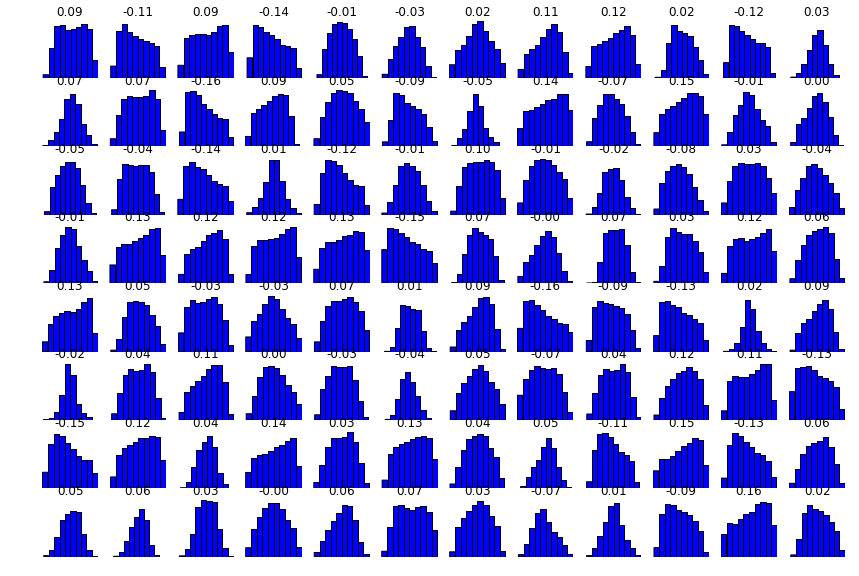

In [26]:
plot_patches(centroids_1000)
plot_activations(activations_1000)

In [113]:
mquantiles(activations_1000, prob=0.9, axis=0).mean()

0.53739747665851156

In [27]:
from sklearn.feature_extraction.image import extract_patches_2d

In [28]:
%time patches_0 = extract_patches_2d(faces_train[0], (8, 8))

CPU times: user 1.17 ms, sys: 782 µs, total: 1.96 ms
Wall time: 1.4 ms


In [29]:
patches_0.shape

(3249, 8, 8)

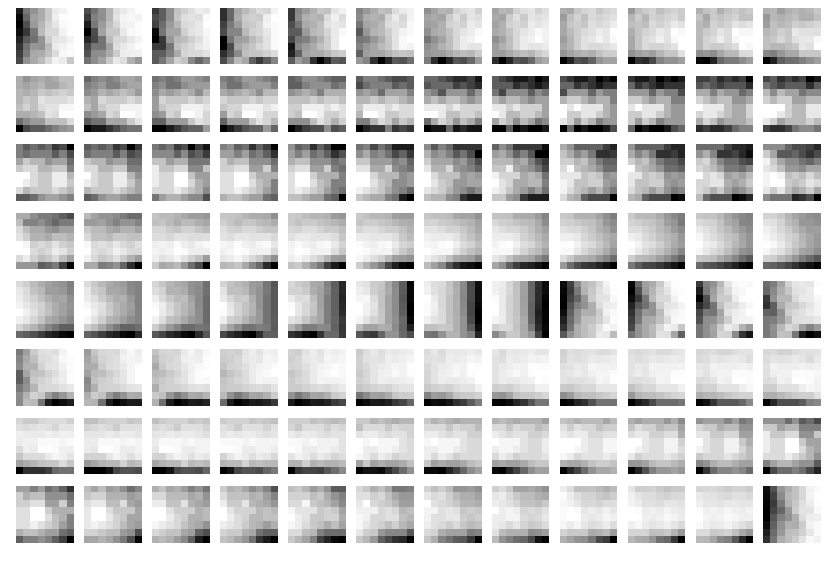

In [30]:
plot_patches(patches_0)

In [86]:
from scipy import linalg
from sklearn.utils import array2d, as_float_array
from sklearn.base import TransformerMixin, BaseEstimator
 
 
class ZCA(BaseEstimator, TransformerMixin):
 
    def __init__(self, regularization=10**-5, copy=False):
        self.regularization = regularization
        self.copy = copy
     
    def fit(self, X, y=None):
        X = array2d(X)
        X = as_float_array(X, copy = self.copy)
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        sigma = np.dot(X.T, X) # / X.shape[1]
        U, S, V = linalg.svd(sigma)
        tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization))) * np.sqrt(X.shape[0])
        self.components_ = np.dot(tmp, U.T)
        return self
     
    def transform(self, X):
        X = array2d(X)
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed

In [87]:
%time patches_zca = ZCA().fit_transform(patches)

CPU times: user 279 ms, sys: 55.6 ms, total: 335 ms
Wall time: 279 ms


In [88]:
patches_zca.std(axis=0)

array([ 0.99999995,  0.99999991,  0.99999991,  0.9999999 ,  0.9999999 ,
        0.99999991,  0.99999991,  0.99999995,  0.9999999 ,  0.99999986,
        0.99999986,  0.99999985,  0.99999985,  0.99999985,  0.99999985,
        0.99999989,  0.99999989,  0.99999985,  0.99999984,  0.99999984,
        0.99999984,  0.99999984,  0.99999984,  0.99999988,  0.99999988,
        0.99999985,  0.99999984,  0.99999984,  0.99999984,  0.99999984,
        0.99999984,  0.99999988,  0.99999988,  0.99999985,  0.99999984,
        0.99999984,  0.99999984,  0.99999984,  0.99999984,  0.99999988,
        0.99999989,  0.99999985,  0.99999984,  0.99999985,  0.99999985,
        0.99999984,  0.99999984,  0.99999988,  0.9999999 ,  0.99999987,
        0.99999986,  0.99999986,  0.99999986,  0.99999986,  0.99999986,
        0.9999999 ,  0.99999995,  0.99999992,  0.99999991,  0.99999991,
        0.99999991,  0.99999991,  0.99999991,  0.99999995])

In [96]:
patches_zca_normalized = normalize(patches_zca)

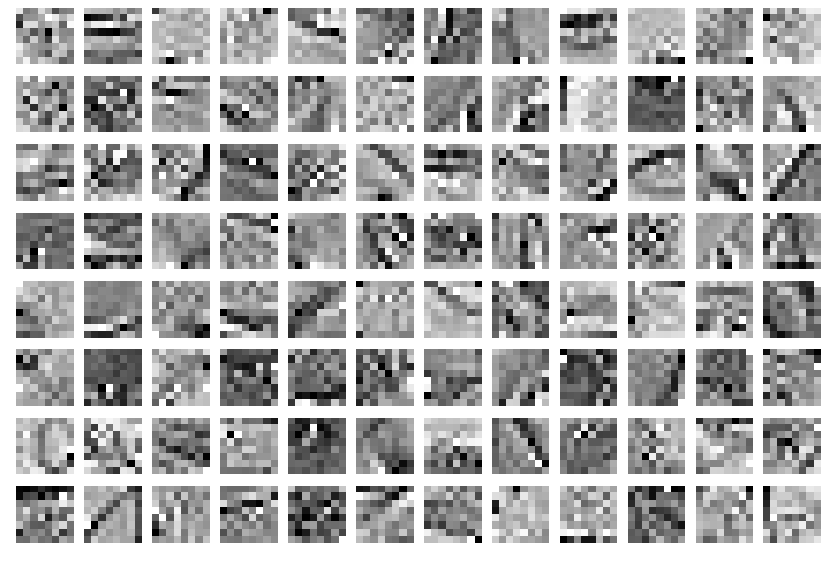

In [95]:
plot_patches(patches_zca_normalized)

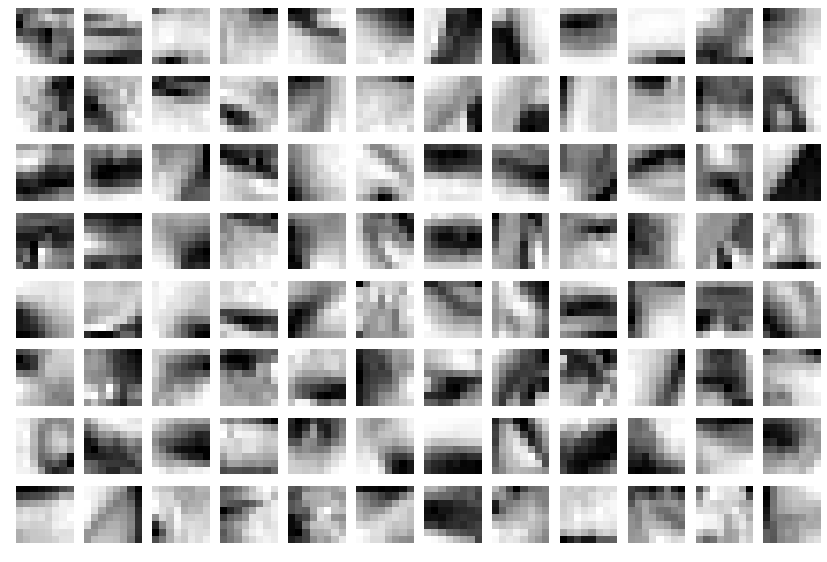

In [79]:
plot_patches(patches)

In [97]:
km_1000_zca = MiniBatchKMeans(n_clusters=1000, batch_size=1000, verbose=0, n_init=3, random_state=42)
%time km_1000_zca.fit(patches_zca_normalized)

CPU times: user 34 s, sys: 1.84 s, total: 35.8 s
Wall time: 34.5 s


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=1000, n_init=3, random_state=42,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [98]:
centroids_1000_zca = normalize(km_1000_zca.cluster_centers_)
activations_1000_zca = np.dot(patches_zca_normalized, centroids_1000_zca.T)

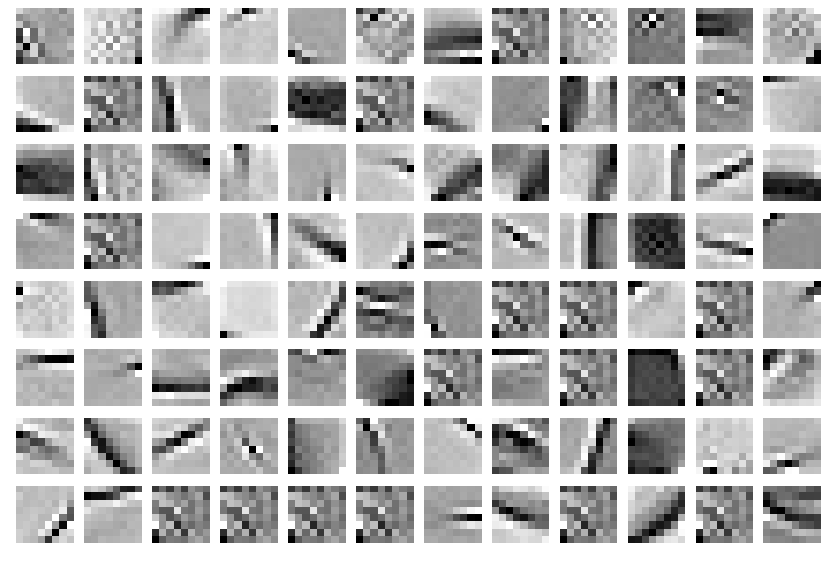

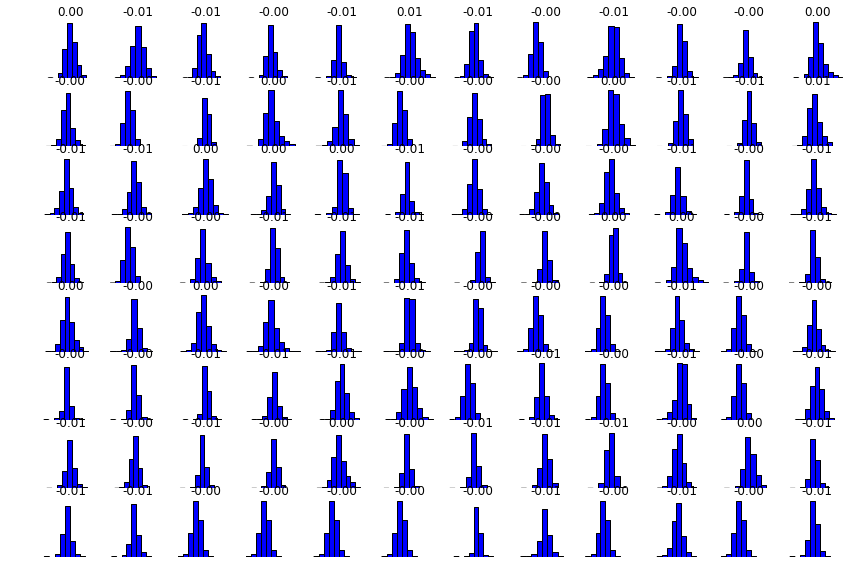

In [99]:
plot_patches(centroids_1000_zca)
plot_activations(activations_1000_zca)

In [115]:
q90 = mquantiles(activations_1000_zca, prob=0.9, axis=0)

In [117]:
q90.min(), np.median(q90), q90.mean(), q90.max()

(0.098011454849816881,
 0.16891624485345302,
 0.16801724987873315,
 0.33636003134520914)

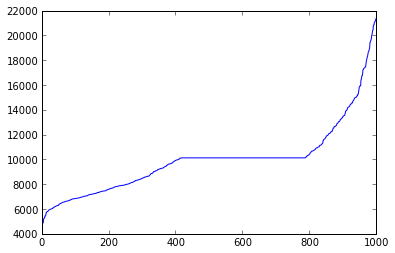

In [122]:
pl.plot(sorted(np.sum(activations_1000_zca > q90.mean(), axis=0)))